In [29]:
from dependencies import *
from save_data import *
from defaults import *

In [30]:
# number of runs to analyze
iters = 100_000
iter_str = str(iters) if iters < 1000 else f"{int(iters/1000)}k"

# read in file and summary stats
filename = f"data/Franklin_{iter_str}.nc"
read_summary_stats(filename)

# save temperature data to plot
with Dataset(filename, "r") as ds:
    min_T = ds.groups['stats'].variables['min_temp'][:]
    min_T_normed = ds.groups['stats'].variables['min_normed_temp'][:]
    min_T_normed = min_T_normed[~np.isnan(min_T_normed)]

Reading summary statistics from data/Franklin_100k.nc
Average cooling: -5.25 K
Late flag percentage: 27.36%
Early flag percentage: 18.00%
Snowball flag percentage: 9.36%


In [47]:
def plot_temp_density(filename,figname=None,
                      normed=False,threshold=280,
                      hist=False,kdeplot=True,fill=False,
                      extra_labels=False):
    # fetch data
    with Dataset(filename, "r") as ds:
        if not normed:
            min_T = ds.groups['stats'].variables['min_temp'][:]
        else:
            min_T = ds.groups['stats'].variables['min_normed_temp'][:]
    
    # filter out nans
    min_T = min_T[~np.isnan(min_T)]
    
    fig,ax = plt.subplots(figsize=(4,2.5))
    if hist:
        ax.hist(min_T,bins=100,density=True,color='k',alpha=0.3,histtype='step',
               label='binned data' if hist and kdeplot and extra_labels else None)
    if kdeplot:
        kde = sns.kdeplot(min_T, color='k',
                          bw_adjust=0.2 if normed else 1,
                          clip=(min_T.min(), min_T.max()),
                          label='KDE-smoothed' if hist and kdeplot and extra_labels else None)
        if fill:
            x_values = np.array(kde.get_lines()[0].get_xdata())
            y_values = np.array(kde.get_lines()[0].get_ydata())
            ax.fill_between(x_values, y_values, where=(x_values <= threshold),
                            color='cadetblue', alpha=0.3)
        
    ax.set_xlim(245,305) if not normed else ax.set_xlim(-40,5)
    if threshold and threshold>ax.get_xlim()[0] and threshold<ax.get_xlim()[1]:
        ax.axvline(threshold, color='cadetblue', label='Snowball threshold')
        
    ax.set_xlabel('Minimum temperature (K) within 2.15 Myr') if not normed else ax.set_xlabel('Min. temperature anomaly ($\Delta$K) within 2.15 Myr')
    ax.set_ylabel('Probability Density')
    ax.set_yticks([])
    ax.legend(loc='upper left',frameon=False)
    
    plt.tight_layout()
    if figname:
        plt.savefig(figname+'.jpg',format='jpg',bbox_inches='tight',dpi=600)
    plt.show()

In [48]:
plt.rcParams.update({'legend.fontsize':9,
                     'font.size':10,
                     'lines.linewidth':1,
                     'axes.titlesize':10})

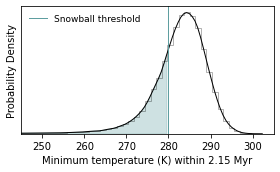

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


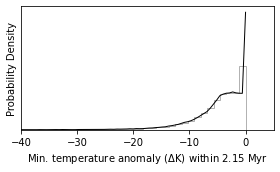

In [51]:
plot_temp_density(filename,"figs/Franklin",hist=True,fill=True)
plot_temp_density(filename,hist=True,normed=True)

In [52]:
np.nanmean(min_T_normed)

-5.251951801066549

In [53]:
def make_label(var_object):
    long_name = var_object.long_name
    units = var_object.units.replace("^2", "$^2$")
    label = f"{long_name} ({units})" if units else long_name
    return label

In [59]:
def param_density_plot(filename, param_name,
                       ax=None, labels_on=False, label_wrap=True,
                      print_progress=False):    
    with Dataset(filename, 'r') as ds:
        param_data = ds.groups['params'].variables[param_name][:]
        late_flag = ds.groups['stats'].variables['late_flag'][:]
        snowball_flag = ds.groups['stats'].variables['snowball_flag'][:]
        
        try:
            x_label = make_label(ds.groups['params'].variables[param_name])
        except:
            print(f"Couldn't find metadata for {param_name}")
            x_label = param_name
            
    if print_progress:
        mean_all = np.mean(param_data)
        mean_late = np.mean(param_data[late_flag == 1])
        mean_snowball = np.mean(param_data[snowball_flag == 1])
        print(f"    Mean of {param_name} (whole space): {mean_all:.4f}")
        print(f"    Mean of {param_name} (snowball any time): {mean_late:.4f}")
        print(f"    Mean of {param_name} (snowball right time): {mean_snowball:.4f}")
    
    
    ax_given = ax
    if not ax:
        fig,ax = plt.subplots(figsize=(4,2.5))
        labels_on = True
        
    labels = ['Distribution\nsampled','Snowball in\n<2.15 Myr','Snowball in\n0.9-2.15 Myr']
    if not label_wrap:
        labels = [label.replace('\n',' ') for label in labels]
    if not labels_on:
        labels = [None,None,None]
        
    sns.kdeplot(param_data, ax=ax, color='#4D4D4D',label=labels[0])
    sns.kdeplot(param_data[late_flag == 1], ax=ax, color='#8566CC',label=labels[1])
    sns.kdeplot(param_data[snowball_flag == 1], ax=ax, color='#47B3A1',label=labels[2])

    #ax.set_yticks([])
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability Density')
    if not ax_given:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=3)
    return ax

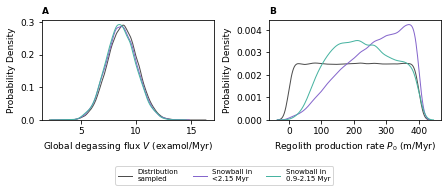

In [64]:
plt.rcParams.update({'legend.fontsize': 7,
                     'font.size': 9,
                     'lines.linewidth': 1,
                     'axes.titlesize': 9})

fig, axs = plt.subplots(1,2, figsize=(6.3,2.3))

ax = axs[0]
param_name = 'V'
ax.set_title('A', loc='left', fontweight='bold')
param_density_plot(filename=filename,param_name=param_name,ax=ax)

ax = axs[1]
param_name = 'P0'
ax.set_title('B', loc='left', fontweight='bold')
param_density_plot(filename=filename,param_name=param_name,ax=ax,
                  labels_on=True)

fig.legend(loc='upper center', bbox_to_anchor=(0.5,-0.0), ncol=3)

plt.tight_layout()
#plt.subplots_adjust(hspace=0.2)
plt.savefig('figs/select_params'+'.jpg',format='jpg',bbox_inches='tight',dpi=600)
plt.show()

Plotting N0
    Mean of N0 (whole space): 8.2312
    Mean of N0 (snowball any time): 7.8834
    Mean of N0 (snowball right time): 8.7135
Plotting T0
    Mean of T0 (whole space): 287.7082
    Mean of T0 (snowball any time): 285.1685
    Mean of T0 (snowball right time): 286.2913
Plotting b
    Mean of b (whole space): 5.4895
    Mean of b (snowball any time): 5.4959
    Mean of b (snowball right time): 5.4941
Plotting V
    Mean of V (whole space): 8.7896
    Mean of V (snowball any time): 8.6715
    Mean of V (snowball right time): 8.6158
Plotting degass
    Mean of degass (whole space): 5.0033
    Mean of degass (snowball any time): 4.7517
    Mean of degass (snowball right time): 5.4682
Plotting A0
    Mean of A0 (whole space): 6.8050
    Mean of A0 (snowball any time): 7.6838
    Mean of A0 (snowball right time): 7.0562
Plotting B0
    Mean of B0 (whole space): 2.0553
    Mean of B0 (snowball any time): 2.2552
    Mean of B0 (snowball right time): 2.3317
Plotting emp_dur
    Mean o

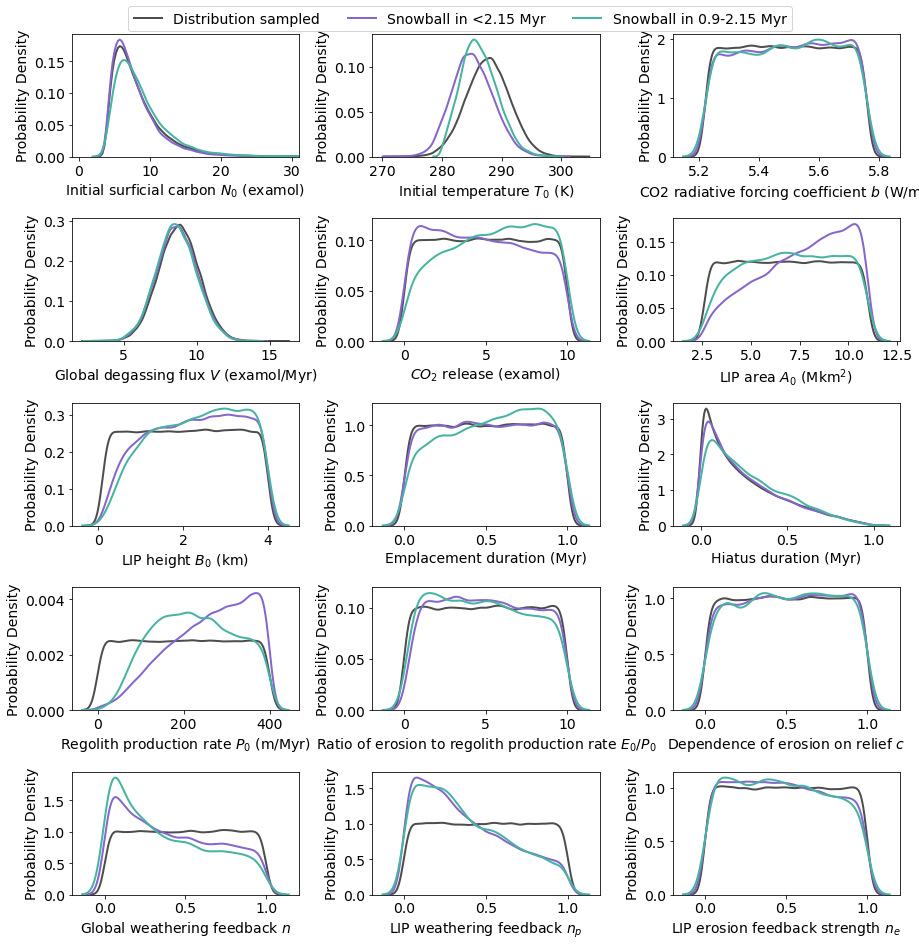

In [63]:
plt.rcParams.update({'legend.fontsize':12,
                     'font.size':14,
                     'lines.linewidth':2})

# in order to plot
param_list = ['N0','T0','b', # background climate
              'V','degass','A0', # emplacement 1
              'B0','emp_dur','erup_freq', # emplacement 2
              'P0','E_P','c', # weathering & erosion
              'n','n_p','n_e'] # feedback strengths

fig,axs = plt.subplots(5,3,figsize=(13,13))

for i in range(len(param_list)):
    ax = axs.reshape(-1)[i]
    param_name = param_list[i]
    print("Plotting",param_name)
    if param_name == 'N0':
        ax.set_xlim(-1,31)
    if i == 0:
        param_density_plot(filename=filename,param_name=param_name,ax=ax,print_progress=True,
                           labels_on=True,label_wrap=False)
    else:
        param_density_plot(filename=filename,param_name=param_name,ax=ax,print_progress=True)
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=14)

plt.tight_layout()
plt.savefig('figs/parameters'+'.jpg',format='jpg',bbox_inches='tight',dpi=600)
plt.show()